In [1]:
import os

root = "/home/hanish-ch/Downloads/smoking_dataset"
for root_dir, dirs, files in os.walk(root):
    print("📁", root_dir)
    for d in dirs:
        print("   📂", d)
    for f in files:
        print("   📄", f)

📁 /home/hanish-ch/Downloads/smoking_dataset
   📂 DATA SET
📁 /home/hanish-ch/Downloads/smoking_dataset/DATA SET
   📂 Non-Smoker
   📂 Smokers
📁 /home/hanish-ch/Downloads/smoking_dataset/DATA SET/Non-Smoker
   📄 notsmoking_0202.jpg
   📄 notsmoking_0153.jpg
   📄 notsmoking_0532.jpg
   📄 notsmoking_0531.jpg
   📄 notsmoking_0053.jpg
   📄 notsmoking_0180.jpg
   📄 notsmoking_0538.jpg
   📄 notsmoking_0163.jpg
   📄 notsmoking_0521.jpg
   📄 notsmoking_0549.jpg
   📄 notsmoking_0032.jpg
   📄 notsmoking_0185.jpg
   📄 notsmoking_0130.jpg
   📄 notsmoking_0041.jpg
   📄 notsmoking_0533.jpg
   📄 notsmoking_0522.jpg
   📄 notsmoking_0056.jpg
   📄 notsmoking_0190.jpg
   📄 notsmoking_0085.jpg
   📄 notsmoking_0534.jpg
   📄 notsmoking_0004.jpg
   📄 notsmoking_0116.jpg
   📄 notsmoking_0124.jpg
   📄 notsmoking_0525.jpg
   📄 notsmoking_0147.jpg
   📄 notsmoking_0504.jpg
   📄 notsmoking_0500.jpg
   📄 notsmoking_0509.jpg
   📄 notsmoking_0133.jpg
   📄 notsmoking_0104.jpg
   📄 notsmoking_0062.jpg
   📄 notsmoking_0095.

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

IMG_SIZE = (160, 160)
CLASSES = ["Smokers", "Non-Smoker"]
data_path = "/home/hanish-ch/Downloads/smoking_dataset/DATA SET"

images = []
labels = []

for idx, class_name in enumerate(CLASSES):
    folder_path = os.path.join(data_path, class_name)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        try:
            img = load_img(file_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(idx)
        except Exception as e:
            print(f"Skipped: {file_path} — {e}")

images = np.array(images)
labels = np.array(labels)

print("Loaded images:", len(images))
print("Label distribution:", np.bincount(labels))

Loaded images: 127
Label distribution: [66 61]


In [4]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [11]:
def get_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model 

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import tensorflow as tf
import numpy as np
import os
from datetime import datetime

def log(msg):
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] {msg}", flush=True)

def run_kfold_training(images, labels, kf, get_model_func, class_names, save_dir):
    fold = 1
    accuracies = []

    log("🚀 K-Fold training started...")

    for train_idx, val_idx in kf.split(images):
        log(f"🔁 Starting Fold {fold}")

        x_train, x_val = images[train_idx], images[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        model, base_model = get_model_func()

        # Step 1: Train top layers with frozen base
        log(f"🧠 Training top layers for Fold {fold}...")
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=10,
            batch_size=8,
            verbose=1,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Step 2: Fine-tune base model
        log(f"🔧 Unfreezing base model for fine-tuning in Fold {fold}...")
        base_model.trainable = True
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        log(f"🧠 Fine-tuning full model for Fold {fold}...")
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=5,
            batch_size=8,
            verbose=1,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Step 3: Evaluation
        log(f"📊 Evaluating model for Fold {fold}...")
        y_pred = (model.predict(x_val) >= 0.5).astype(int).flatten()
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)

        log(f"✅ Fold {fold} Accuracy: {acc:.4f}")
        print("📋 Classification Report:\n", classification_report(y_val, y_pred, target_names=class_names))
        print("🧩 Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

        model_path = os.path.join(save_dir, f"mobilenetv2_fold{fold}.h5")
        model.save(model_path)
        log(f"💾 Saved model for Fold {fold} to: {model_path}")

        # Clear session and move to next fold
        K.clear_session()
        fold += 1

    log("✅ K-Fold training completed.")
    log(f"📈 Average Accuracy: {np.mean(accuracies):.4f}")

    return accuracies, model, save_dir

In [28]:
accuracies, model, save_dir = run_kfold_training(
    images=images,
    labels=labels,
    kf=kf,
    get_model_func=get_model,
    class_names=CLASSES,
    save_dir="/home/hanish-ch/Downloads"
)

[2025-07-22 13:54:21] 🚀 K-Fold training started...
[2025-07-22 13:54:21] 🔁 Starting Fold 1
[2025-07-22 13:54:23] 🧠 Training top layers for Fold 1...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - accuracy: 0.6091 - loss: 0.7723 - val_accuracy: 0.7692 - val_loss: 0.4971
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.8901 - loss: 0.2627 - val_accuracy: 0.8077 - val_loss: 0.4795
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9282 - loss: 0.1933 - val_accuracy: 0.7692 - val_loss: 0.6479
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9472 - loss: 0.1652 - val_accuracy: 0.8077 - val_loss: 0.5769
[2025-07-22 13:54:34] 🔧 Unfreezing base model for fine-tuning in Fold 1...
[2025-07-22 13:54:34] 🧠 Fine-tuning full model for Fold 1...
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - accuracy: 0.4931 - loss: 1.2067 - val_accuracy: 0.8077 - val_loss: 0.4840
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 381ms/step - accuracy: 0.6035 - loss

📋 Classification Report:
               precision    recall  f1-score   support

     Smokers       0.79      0.85      0.81        13
  Non-Smoker       0.83      0.77      0.80        13

    accuracy                           0.81        26
   macro avg       0.81      0.81      0.81        26
weighted avg       0.81      0.81      0.81        26

🧩 Confusion Matrix:
 [[11  2]
 [ 3 10]]
[2025-07-22 13:55:15] 💾 Saved model for Fold 1 to: /home/hanish-ch/Downloads/mobilenetv2_fold1.h5
[2025-07-22 13:55:18] 🔁 Starting Fold 2
[2025-07-22 13:55:19] 🧠 Training top layers for Fold 2...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.6079 - loss: 0.7190 - val_accuracy: 0.5385 - val_loss: 1.1875
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.8067 - loss: 0.4931 - val_accuracy: 0.6538 - val_loss: 0.6024
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.9081 - loss: 0.2680 - val_accuracy: 0.6923 - val_loss: 0.5198
Epoch 4/10
13/13 ━━━━━━━━━━

📋 Classification Report:
               precision    recall  f1-score   support

     Smokers       0.80      0.75      0.77        16
  Non-Smoker       0.64      0.70      0.67        10

    accuracy                           0.73        26
   macro avg       0.72      0.72      0.72        26
weighted avg       0.74      0.73      0.73        26

🧩 Confusion Matrix:
 [[12  4]
 [ 3  7]]
[2025-07-22 13:56:14] 💾 Saved model for Fold 2 to: /home/hanish-ch/Downloads/mobilenetv2_fold2.h5
[2025-07-22 13:56:17] 🔁 Starting Fold 3
[2025-07-22 13:56:18] 🧠 Training top layers for Fold 3...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.5717 - loss: 0.7546 - val_accuracy: 0.7600 - val_loss: 0.3969
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.8421 - loss: 0.4156 - val_accuracy: 0.8400 - val_loss: 0.3430
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8975 - loss: 0.2405 - val_accuracy: 0.8400 - val_loss: 0.3819
Epoch 4/10
13/13 ━━━━━━━━━━

📋 Classification Report:
               precision    recall  f1-score   support

     Smokers       0.87      0.93      0.90        14
  Non-Smoker       0.90      0.82      0.86        11

    accuracy                           0.88        25
   macro avg       0.88      0.87      0.88        25
weighted avg       0.88      0.88      0.88        25

🧩 Confusion Matrix:
 [[13  1]
 [ 2  9]]
[2025-07-22 13:57:29] 💾 Saved model for Fold 3 to: /home/hanish-ch/Downloads/mobilenetv2_fold3.h5
[2025-07-22 13:57:33] 🔁 Starting Fold 4
[2025-07-22 13:57:34] 🧠 Training top layers for Fold 4...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 273ms/step - accuracy: 0.6337 - loss: 0.7261 - val_accuracy: 0.8400 - val_loss: 0.6194
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.9112 - loss: 0.2935 - val_accuracy: 0.8000 - val_loss: 0.6239
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8913 - loss: 0.1944 - val_accuracy: 0.8000 - val_loss: 0.5908
Epoch 4/10
13/13 ━━━━━━━━━━

📋 Classification Report:
               precision    recall  f1-score   support

     Smokers       0.90      0.75      0.82        12
  Non-Smoker       0.80      0.92      0.86        13

    accuracy                           0.84        25
   macro avg       0.85      0.84      0.84        25
weighted avg       0.85      0.84      0.84        25

🧩 Confusion Matrix:
 [[ 9  3]
 [ 1 12]]
[2025-07-22 13:58:39] 💾 Saved model for Fold 4 to: /home/hanish-ch/Downloads/mobilenetv2_fold4.h5
[2025-07-22 13:58:45] 🔁 Starting Fold 5
[2025-07-22 13:58:46] 🧠 Training top layers for Fold 5...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 402ms/step - accuracy: 0.6378 - loss: 0.6700 - val_accuracy: 0.8400 - val_loss: 0.4100
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.8538 - loss: 0.3419 - val_accuracy: 0.8800 - val_loss: 0.4366
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.8895 - loss: 0.2569 - val_accuracy: 0.9200 - val_loss: 0.4066
Epoch 4/10
13/13 ━━━━━━━━━

📋 Classification Report:
               precision    recall  f1-score   support

     Smokers       0.91      0.91      0.91        11
  Non-Smoker       0.93      0.93      0.93        14

    accuracy                           0.92        25
   macro avg       0.92      0.92      0.92        25
weighted avg       0.92      0.92      0.92        25

🧩 Confusion Matrix:
 [[10  1]
 [ 1 13]]
[2025-07-22 14:00:01] 💾 Saved model for Fold 5 to: /home/hanish-ch/Downloads/mobilenetv2_fold5.h5
[2025-07-22 14:00:05] ✅ K-Fold training completed.
[2025-07-22 14:00:05] 📈 Average Accuracy: 0.8357


In [29]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, images, class_names, num_samples=5):
    sample_images = images[:num_samples]

    for i, img in enumerate(sample_images):
        img_input = np.expand_dims(img, axis=0)
        pred = model.predict(img_input, verbose=0)

        # Extract predicted value safely
        pred_val = pred[0][0] if pred.ndim == 2 else pred[0]
        label = class_names[int(pred_val >= 0.5)]

        # Plot
        plt.imshow(img)
        plt.title(f"Prediction: {label} ({pred_val:.2f})")
        plt.axis('off')
        plt.show()

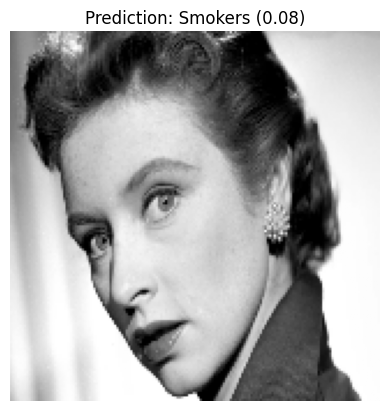

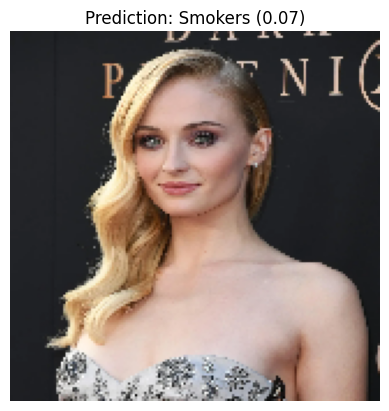

In [30]:
show_predictions(model, images, CLASSES, num_samples=2)

In [31]:
import numpy as np

best_fold_idx = np.argmax(accuracies)
print(f"🏆 Best Fold: {best_fold_idx + 1} with Accuracy: {accuracies[best_fold_idx]:.4f}")

🏆 Best Fold: 5 with Accuracy: 0.9200


In [32]:
from tensorflow.keras.models import load_model
import os

best_model_path = os.path.join(save_dir, f"mobilenetv2_fold{best_fold_idx + 1}.h5")
final_model = load_model(best_model_path)

In [33]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
], name="data_augmentation")

In [34]:
def get_augmented_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1)
    ], name="data_augmentation")

    inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [36]:
model, base_model = get_augmented_model()

history = model.fit(
    images, labels,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 383ms/step - accuracy: 0.4328 - loss: 0.9470 - val_accuracy: 0.7692 - val_loss: 0.5040
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.5939 - loss: 0.7629 - val_accuracy: 0.8462 - val_loss: 0.4735
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.5687 - loss: 0.7040 - val_accuracy: 0.7692 - val_loss: 0.4477
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.6785 - loss: 0.6387 - val_accuracy: 0.7692 - val_loss: 0.4462
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.6616 - loss: 0.7678 - val_accuracy: 0.7692 - val_loss: 0.4334
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - accuracy: 0.6621 - loss: 0.7206 - val_accuracy: 0.7692 - val_loss: 0.4368
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.7774 - loss: 0.5400 - val_accuracy: 0.7692 - val_loss: 0.4270
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.7563 - loss: 0.5938 - val_accuracy: 0.7692 - val_loss:

In [37]:
model.save("mobilenetv2_final_frozen_augmented.h5")

In [38]:
avg_val_accuracy = np.mean(accuracies)
print(f"📈 Average Validation Accuracy across folds: {avg_val_accuracy:.4f}")

📈 Average Validation Accuracy across folds: 0.8357


In [46]:
for layer in base_model.layers[-15:]:
    layer.trainable = True

In [47]:
print(len(base_model.layers)) 

154


In [48]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [49]:
history_finetuned = model.fit(
    images, labels,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 435ms/step - accuracy: 0.6964 - loss: 0.6334 - val_accuracy: 0.6923 - val_loss: 0.4716
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - accuracy: 0.7249 - loss: 0.5655 - val_accuracy: 0.6923 - val_loss: 0.4991
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.6643 - loss: 0.7212 - val_accuracy: 0.6923 - val_loss: 0.5265
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - accuracy: 0.6939 - loss: 0.6464 - val_accuracy: 0.6923 - val_loss: 0.5518


In [50]:
model.save("mobilenetv2_final_finetuned.h5")

In [51]:
val_accs_finetuned = history_finetuned.history['val_accuracy']
avg_val_acc_finetuned = sum(val_accs_finetuned) / len(val_accs_finetuned)

print(f"📈 Avg Val Accuracy after fine-tuning: {avg_val_acc_finetuned:.4f}")

📈 Avg Val Accuracy after fine-tuning: 0.6923


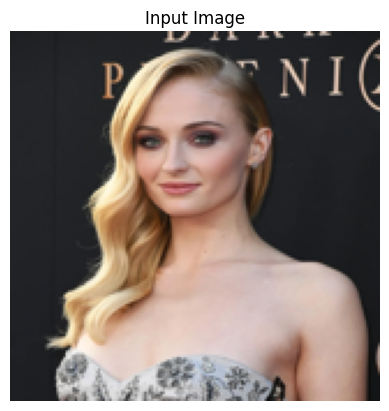

In [102]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

IMG_SIZE = (160, 160)

img_path = "/home/hanish-ch/Downloads/smoking_dataset/DATA SET/Smokers/smoker_13.webp" 
img = Image.open(img_path).convert("RGB").resize(IMG_SIZE)

plt.imshow(img)
plt.axis('off')
plt.title("Input Image")
plt.show()

img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

In [101]:
pip install tf-explain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 929.0 kB/s eta 0:00:001m1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [104]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

explainer = OcclusionSensitivity()

pred = model.predict(img_array)
class_index = pred.argmax()

grid = explainer.explain((img_array, None), model, class_index=class_index, patch_size=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 276ms/step


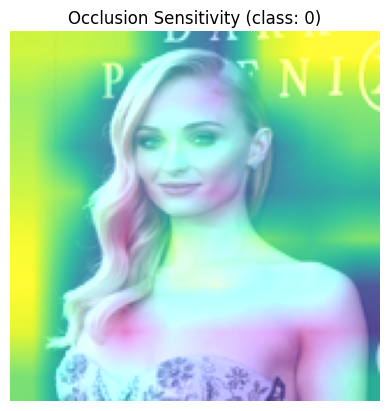

In [105]:
from matplotlib import pyplot as plt

plt.imshow(grid)
plt.axis(False)
plt.title(f"Occlusion Sensitivity (class: {class_index})")
plt.show()

In [107]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [3]:
from tensorflow.keras.models import load_model

model = load_model("/home/hanish-ch/Downloads/mobilenetv2_fold5.h5") 

2025-07-22 16:14:48.035468: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
from keras.utils import plot_model

plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
